In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("/content/heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


EDA & Class Imbalance

In [3]:
df.isnull().sum()

,0
age,0
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


In [ ]:
df.describe()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [ ]:
df['DEATH_EVENT'].value_counts()

# 0 --> survived
# 1 --> death

,count
DEATH_EVENT,
0,203
1,96


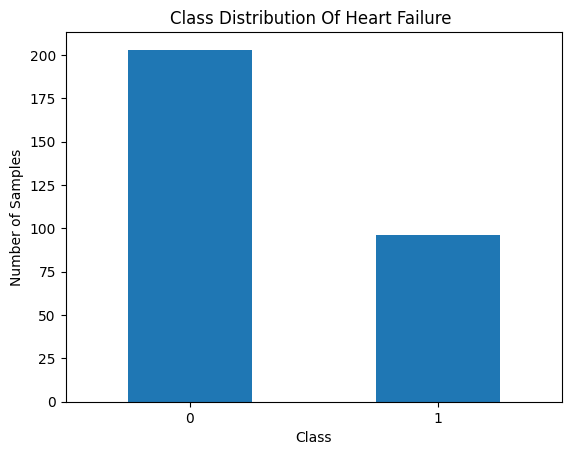

In [ ]:
import matplotlib.pyplot as plt

counts = df['DEATH_EVENT'].value_counts()

plt.figure()
counts.plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution Of Heart Failure ")
plt.xticks(rotation=0)
plt.show()


 GANs for Minority Class



> Vanilla GAN



In [ ]:
minority_df = df[df['DEATH_EVENT'] == 1]
majority_df = df[df['DEATH_EVENT'] == 0]

print("Minority samples:", len(minority_df))
print("Majority samples:", len(majority_df))


Minority samples: 96
Majority samples: 203


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Drop target column
gan_data = minority_df.drop(columns=['DEATH_EVENT'])

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
gan_data_scaled = scaler.fit_transform(gan_data)

gan_data_scaled.shape


(96, 12)

In [ ]:
latent_dim = 32          # Noise vector
data_dim = gan_data_scaled.shape[1]  # Number of features


In [ ]:
from tensorflow.keras import layers, models

def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_dim=latent_dim))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(data_dim, activation='tanh'))
    return model


In [ ]:
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=data_dim))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model


In [ ]:
from tensorflow.keras.optimizers import Adam

# Build models
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002),
    metrics=['accuracy']
)

# GAN model
discriminator.trainable = False

z = layers.Input(shape=(latent_dim,))
fake_data = generator(z)
validity = discriminator(fake_data)

gan = models.Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
epochs = 3000
batch_size = 32

for epoch in range(epochs):

    # Train Discriminator
    idx = np.random.randint(0, gan_data_scaled.shape[0], batch_size)
    real_samples = gan_data_scaled[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = generator.predict(noise, verbose=0)

    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((batch_size, 1)))

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {0.5 * np.add(d_loss_real, d_loss_fake)} | G Loss: {g_loss}")


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D Loss: [0.8516482 0.078125 ] | G Loss: 0.6447372436523438
Epoch 500 | D Loss: [0.9933083  0.02174863] | G Loss: 0.4132844805717468
Epoch 1000 | D Loss: [1.0102618  0.02060954] | G Loss: 0.39453303813934326
Epoch 1500 | D Loss: [1.0159576 0.0208958] | G Loss: 0.3879779279232025
Epoch 2000 | D Loss: [1.0191245  0.02093746] | G Loss: 0.3845334053039551
Epoch 2500 | D Loss: [1.0212028  0.02094372] | G Loss: 0.3823883831501007


In [ ]:
num_samples = len(majority_df) - len(minority_df)

noise = np.random.normal(0, 1, (num_samples, latent_dim))
synthetic_data = generator.predict(noise)

# Inverse scaling
synthetic_data = scaler.inverse_transform(synthetic_data)

synthetic_df = pd.DataFrame(synthetic_data, columns=gan_data.columns)
synthetic_df['DEATH_EVENT'] = 1


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


In [ ]:
balanced_gan_df = pd.concat([df, synthetic_df], ignore_index=True)

balanced_gan_df['DEATH_EVENT'].value_counts()


,count
DEATH_EVENT,
1,203
0,203




> WGAN (Wasserstein GAN)



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop

latent_dim = 32
data_dim = gan_data_scaled.shape[1]

def build_generator():
    m = models.Sequential([
        layers.Dense(64, activation="relu", input_dim=latent_dim),
        layers.Dense(128, activation="relu"),
        layers.Dense(data_dim, activation="tanh")
    ])
    return m

def build_critic():  # (Discriminator in WGAN is called Critic)
    m = models.Sequential([
        layers.Dense(128, activation="relu", input_dim=data_dim),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)   # no sigmoid
    ])
    return m

generator_w = build_generator()
critic = build_critic()

# WGAN loss
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

critic.compile(
    loss=wasserstein_loss,
    optimizer=RMSprop(learning_rate=0.00005)
)

critic.trainable = False
z = layers.Input(shape=(latent_dim,))
fake = generator_w(z)
validity = critic(fake)
wgan = models.Model(z, validity)
wgan.compile(loss=wasserstein_loss, optimizer=RMSprop(learning_rate=0.00005))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
epochs = 3000
batch_size = 32
n_critic = 5
clip_value = 0.01

for epoch in range(epochs):
    for _ in range(n_critic):
        # Sample real
        idx = np.random.randint(0, gan_data_scaled.shape[0], batch_size)
        real_samples = gan_data_scaled[idx]

        # Sample noise and generate fake
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator_w.predict(noise, verbose=0)

        # Train critic: real labels = -1, fake labels = +1 (common WGAN convention)
        c_loss_real = critic.train_on_batch(real_samples, -np.ones((batch_size, 1)))
        c_loss_fake = critic.train_on_batch(fake_samples,  np.ones((batch_size, 1)))
        c_loss = 0.5 * (c_loss_real + c_loss_fake)

        # Weight clipping
        for layer in critic.layers:
            weights = layer.get_weights()
            clipped = [np.clip(w, -clip_value, clip_value) for w in weights]
            layer.set_weights(clipped)

    # Train generator: wants critic output to look "real" => label -1
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = wgan.train_on_batch(noise, -np.ones((batch_size, 1)))

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Critic loss: {c_loss:.4f} | Gen loss: {g_loss:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | Critic loss: 0.0272 | Gen loss: 0.0000
Epoch 500 | Critic loss: 0.0001 | Gen loss: 0.0000
Epoch 1000 | Critic loss: 0.0001 | Gen loss: 0.0000
Epoch 1500 | Critic loss: 0.0001 | Gen loss: 0.0000
Epoch 2000 | Critic loss: 0.0001 | Gen loss: 0.0000
Epoch 2500 | Critic loss: 0.0001 | Gen loss: 0.0000


In [ ]:
num_needed = len(majority_df) - len(minority_df)

noise = np.random.normal(0, 1, (num_needed, latent_dim))
synthetic_w = generator_w.predict(noise, verbose=0)

synthetic_w = scaler.inverse_transform(synthetic_w)
synthetic_w_df = pd.DataFrame(synthetic_w, columns=gan_data.columns)
synthetic_w_df["DEATH_EVENT"] = 1

balanced_wgan_df = pd.concat([df, synthetic_w_df], ignore_index=True)
print(balanced_wgan_df["DEATH_EVENT"].value_counts())


DEATH_EVENT
1    203
0    203
Name: count, dtype: int64




> LSGAN



In [ ]:
from tensorflow.keras.optimizers import Adam

generator_l = build_generator()

def build_discriminator_ls():
    m = models.Sequential([
        layers.Dense(128, activation="relu", input_dim=data_dim),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)  # no sigmoid
    ])
    return m

discriminator_l = build_discriminator_ls()

mse = tf.keras.losses.MeanSquaredError()

discriminator_l.compile(optimizer=Adam(0.0002), loss=mse)

discriminator_l.trainable = False
z = layers.Input(shape=(latent_dim,))
fake = generator_l(z)
validity = discriminator_l(fake)
lsgan = models.Model(z, validity)
lsgan.compile(optimizer=Adam(0.0002), loss=mse)


In [ ]:
epochs = 3000
batch_size = 32

for epoch in range(epochs):
    # real batch
    idx = np.random.randint(0, gan_data_scaled.shape[0], batch_size)
    real_samples = gan_data_scaled[idx]

    # fake batch
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = generator_l.predict(noise, verbose=0)

    # LSGAN labels: real=1, fake=0
    d_loss_real = discriminator_l.train_on_batch(real_samples, np.ones((batch_size, 1)))
    d_loss_fake = discriminator_l.train_on_batch(fake_samples, np.zeros((batch_size, 1)))
    d_loss = 0.5 * (d_loss_real + d_loss_fake)

    # Train generator wants discriminator output close to 1
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = lsgan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D loss: {d_loss:.4f} | G loss: {g_loss:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D loss: 0.4740 | G loss: 0.8202
Epoch 500 | D loss: 0.5349 | G loss: 0.1696
Epoch 1000 | D loss: 0.6045 | G loss: 0.0985
Epoch 1500 | D loss: 0.6287 | G loss: 0.0741
Epoch 2000 | D loss: 0.6408 | G loss: 0.0619
Epoch 2500 | D loss: 0.6486 | G loss: 0.0545


In [ ]:
num_needed = len(majority_df) - len(minority_df)

noise = np.random.normal(0, 1, (num_needed, latent_dim))
synthetic_ls = generator_l.predict(noise, verbose=0)

synthetic_ls = scaler.inverse_transform(synthetic_ls)
synthetic_ls_df = pd.DataFrame(synthetic_ls, columns=gan_data.columns)
synthetic_ls_df["DEATH_EVENT"] = 1

balanced_lsgan_df = pd.concat([df, synthetic_ls_df], ignore_index=True)
print(balanced_lsgan_df["DEATH_EVENT"].value_counts())


DEATH_EVENT
1    203
0    203
Name: count, dtype: int64


Classification Experiments (MLP)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import models, layers


In [4]:
def build_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_dim=input_dim))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model


In [ ]:
def train_and_evaluate(dataset, dataset_name):
    # Split features and target
    X = dataset.drop(columns=['DEATH_EVENT'])
    y = dataset['DEATH_EVENT']

    # Train / Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Build classifier
    model = build_mlp(X_train.shape[1])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Predict
    y_prob = model.predict(X_test)
    y_pred = (y_prob > 0.5).astype(int)

    # Metrics
    return {
        "Dataset": dataset_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    }


In [ ]:
results = []

results.append(train_and_evaluate(df, "Imbalanced"))
results.append(train_and_evaluate(balanced_gan_df, "Vanilla GAN"))
results.append(train_and_evaluate(balanced_wgan_df, "WGAN"))
results.append(train_and_evaluate(balanced_lsgan_df, "LSGAN"))

results_df = pd.DataFrame(results)
results_df


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


,Dataset,Accuracy,Precision,Recall,F1-score
0,Imbalanced,0.783333,0.714286,0.526316,0.606061
1,Vanilla GAN,0.878049,0.918919,0.829268,0.871795
2,WGAN,0.853659,0.891892,0.804878,0.846154
3,LSGAN,0.890244,0.921053,0.853659,0.886076


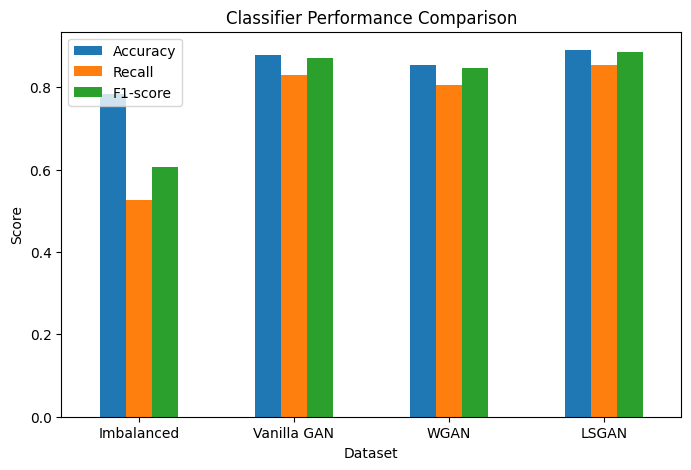

In [ ]:
import matplotlib.pyplot as plt

results_df.set_index("Dataset")[["Accuracy", "Recall", "F1-score"]].plot(
    kind="bar", figsize=(8,5)
)
plt.title("Classifier Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()
